In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import TruncatedSVD
import time
import atexit
import random


class BookRecommendation(object):

    def __init__(self, verbose=0):
        """
        params:
            verbose -> int
                if verbose > 0:
                    print progress
        """
        init_timer = time.time()
        self.df_r, self.df_b, self.df_bt, self.df_t = self._load_df(verbose=verbose)
        self.corr = self._init_corr(verbose=verbose)
        self.title_series = self.df_b["title"]
        if verbose > 0:
            print("Time to init:", time.time() - init_timer, "sec")
        self.base_update = False
        # use atexit if you want to update the database at the end of script
        #atexit.register(self.exit)
        #self.rating_mean = self.df_r["rating"].mean()
        self.rating_mean = 2.5

        
    def update_database(self):
        if self.base_update:
            df_r.to_csv("ratings.csv", index=False)
            self.base_update=False
    
    
    def exit(self):
        self.update_database()
        

    def _load_df(self, verbose=0):
        if verbose > 0:
            print("Loading ratings.csv ...")
        df_r = pd.read_csv('ratings.csv')
        df_r.sort_values(by="user_id", inplace=True, ignore_index=True)
        df_r = df_r.reset_index(drop=True)
        if verbose > 0:
            print("Done")
            print("Loading books.csv ...")
        df_b = pd.read_csv('books.csv')
        if verbose > 0:
            print("Done")
            print("Loading book_tags.csv ...")
        df_bt = pd.read_csv('book_tags.csv')
        if verbose > 0:
            print("Done")
            print("Loading tags.csv ...")
        df_t = pd.read_csv('tags.csv')
        if verbose > 0:
            print("Done")
        return df_r, df_b, df_bt, df_t


    def _init_corr(self, verbose=0):
        if verbose > 0:
            print("Loading matrix ...")
        df_r_pivot = self.df_r.pivot(index="book_id", columns ="user_id", values="rating")
        df_r_pivot = df_r_pivot.fillna(0)
        X = df_r_pivot.values
#         if verbose > 0:
#             print("Done")
#             print("Fiting SVD ...")
        # SVD = TruncatedSVD(n_components=n_components, random_state=42)
        # matrix = SVD.fit_transform(X)
        if verbose > 0:
            print("Done")
            print("Loading corr ...")
        #corr = np.corrcoef(matrix)
        corr = np.corrcoef(X)
        if verbose > 0:
            print("Done")
        return corr
        

    def show_book_title_from_id(self, book_id):
        book_title = self.df_b.loc[self.df_b["book_id"] == book_id, "title"].values[0]
        print(book_id, book_title)


    def show_books(self, start, end):
        while start < end and start < len(self.title_series):
            print("book_id", start+1, "title", self.title_series[start])
            start += 1


    def related_books(self, book, n_books=10, unwanted_id=[]):
        idx = []
        if type(book) == str:
            book_id = self.df_b.loc[self.df_b["title"] == book, "book_id"].values[0]
        elif type(book) == int:
            book_id = book
        else:
            return idx
        
        book_corr = self.corr[book - 1]
        idx = (-book_corr).argsort()
        
        i = 0
        while i < len(idx):
            idx[i] += 1
            i += 1

        new_idx = []
        i = 0
        while len(new_idx) < n_books and i < len(idx):
            if idx[i] not in unanted_id:
                new_idx.append(idx[i])
            i += 1
            
        return new_idx


    def show_books_from_user_id(self, user_id):
        df_user = self.df_r[self.df_r["user_id"] == user_id]
        df_user = df_user.sort_values(by="rating", ascending=False, ignore_index=True)
        for i in df_user.index:
            print(self.df_b[self.df_b["book_id"] == df_user["book_id"][i]]["title"].values[0], df_user["rating"][i])


    def recommend_books_from_user_id(self, user_id, n_books=100):
        """
        Recommend books for a user in our database.
        If he's not in our database we're recommanding typical best rated books
        params:
            user_id -> int
            n_books -> int; n_books >= 1
        """
        
        # get ratings of user
        df_user = self.df_r[self.df_r["user_id"] == user_id]
        
        # size of list we wanna create; we're gonna return n_books value randomly inside
        book_list_size = n_books * 3
        
        # if user didn't read any book return typical best rated books
        if len(df_user) == 0:
            book_list = self.popularity_recommender(book_list_size)
            # shuffle
            random.shuffle(book_list)
            return book_list[:n_books]
        
        # sort books rated by user by rating (descending)
        df_user = df_user.sort_values(by="rating", ascending=False, ignore_index=True)
        
        # get list of id of books rated by user
        user_read_books = df_user["book_id"].values.tolist()
        
        # count how many books the user liked (liked means: rating >= average_all_ratings)
        liked_books = df_user[df_user["rating"] >= self.rating_mean].count()
    
        # for each book liked, we're recommanding others books the user didn't read already
        # these books are the most related with books the user liked the most
        stars_count = []
        for i in range(0, 5):
            stars_count.append(len(df_user[df_user["rating"] == i + 1]))

        min_accepted = int(np.ceil(self.rating_mean))
        
        i = 0
        while min_accepted + i <= 5:
            if stars_count[min_accepted + i - 1] > 0:
                min_rated_in_accepted_ratings = min_accepted + i
                break
            i += 1
            
        denominator = 0
        i = 0
        while min_accepted + i <= 5:
            denominator += stars_count[min_accepted + i - 1] * np.power(2, i)
            i += 1
            
        print("self.rating_mean", self.rating_mean)
        
        book_list = []
        i = 0
        while i < len(df_user.index):
            if df_user["rating"][df_user.index[i]] < self.rating_mean:
                break
                
            nominator = np.power(2, df_user["rating"][df_user.index[i]] - min_rated_in_accepted_ratings)
            wanted_n_books = int(np.ceil(nominator * (book_list_size / denominator)))
            
            print("actual stars", df_user["rating"][df_user.index[i]])
            print("nominator", nominator)
            print("denominator", denominator)
            print("wanted_n_books non rounded", nominator * (book_list_size / denominator))
            print("wanted_n_books rounded", wanted_n_books)
            
            book_list += self.related_books(book=df_user["book_id"][df_user.index[i]],
                                            n_books=wanted_n_books, unwanted_id=book_list+user_read_books)
            i += 1
                
        if len(book_list) < book_list_size:
            book_list += self.popularity_recommender(n_books=book_list_size-len(book_list), unwanted_id=book_list+user_read_books)
            
        # shuffle
        random.shuffle(book_list)

        return book_list[:n_books]
    
    
    def popularity_recommender(self, n_books=50, unwanted_id=[]):
        # goal: create a dataframe of weighted ratings for each book, and return the 
        # indexes of the n_books best rated books.
        # (v*R + m*C) / (v+m)
        # v: number of votes for the book
        # m: minimum number of votes required to appear in the list
        # R: average rating of the book
        # C: mean value of all the votes
        # create a pandas Dataframe with book_id and the number of ratings for the book
        df_wr = self.df_r[["book_id", "rating"]].groupby("book_id", as_index=False).count().rename(columns={"rating": "v"})
        # add the mean score for each book
        df_wr["R"] = self.df_r[["book_id", "rating"]].groupby("book_id", as_index=False).mean()["rating"]
        # let m be the median of the numbers of votes (248)
        m = df_wr["v"].quantile(0.90)
        # print(m)
        C = self.df_r["rating"].mean()
        # compute the weighted ratings for each books
        df_wr["wr"] = df_wr.apply(lambda row: (row["v"]*row["R"] + m*C) / (row["v"] + m), axis=1)
        # sort the books by their weighted ratings
        df_wr = df_wr.sort_values(by="wr", ascending=False, ignore_index=True).reset_index(drop=True)
        book_list = []
        i = 0
        while len(book_list) < n_books and i < len(df_wr):
            if df_wr["book_id"][i] not in unwanted_id:
                book_list.append(df_wr["book_id"][i])
            i += 1
        return book_list

    
    def add_ratings(self, user_id, book_id, rating):
        """
         if user doesn't exist -> create user
        """
        if len(book_id) == 0 or len(book_id) != len(rating):
            # print("wrong params")
            return
        
        if self.df_r[self.df_r["user_id"] == user_id].shape[0] > 0:
            # if user already exist
            # drop doublons
            all_books = self.df_r[self.df_r["user_id"] == user_id]["book_id"].values.tolist()
            known_books = []
            for i in all_books:
                if i in book_id:
                    known_books.append(i)
            i = 0
            while i < len(book_id):
                if book_id[i] in known_books:
                    book_id.pop(i)
                    rating.pop(i)
                    i -= 1
                i += 1
            if len(book_id) == 0 or len(book_id) != len(rating):
                return
            # and then add book_id and ratings on known user
        
        _dict = {"user_id": [user_id]*len(book_id), "book_id": book_id, "rating": rating}
        df = pd.DataFrame(data=_dict)
        self.df_r = self.df_r.append(df, ignore_index=True)
        self.base_update = True

        
    def del_user(self, user_id):
        self.df_r = self.df_r.drop(self.df_r[self.df_r["user_id"] == user_id].index)
        self.df_r.reset_index(drop=True)

In [2]:
book_recommendation = BookRecommendation(verbose=1)

Loading ratings.csv ...
Done
Loading books.csv ...
Done
Loading book_tags.csv ...
Done
Loading tags.csv ...
Done
Loading matrix ...
Done
Loading corr ...
Done
Time to init: 60.95341110229492 sec


In [97]:
def show_books(start=0, end=10):
    print("\n", str(" "+str(start)+" ").center(50, "-"))
    book_recommendation.show_books(start, end)
    print(str(" "+str(end)+" ").center(50, "-"), "\n")

    
def show_related_books(book_id, n_books=10):
    book_recommendation.show_book_title_from_id(book_id)
    book_list = book_recommendation.related_books(book=book_id, n_books=n_books)
    print("\n", " 0 ".center(50, "-"))
    for i in book_list:
        book_recommendation.show_book_title_from_id(i)
    print("\n", str(" "+str(n_books)+" ").center(50, "-"))
    
    
def show_user(user_id):
    book_recommendation.show_books_from_user_id(user_id)

    
def recommend_user(user_id, n_books=10):
    print("\n", " already read ".center(50, "-"))
    book_recommendation.show_books_from_user_id(user_id)
    print("\n", " end ".center(50, "-"))
    print("\n", " recommendations ".center(50, "-"))
    book_list = book_recommendation.recommend_books_from_user_id(user_id, n_books=n_books)
    print("nb_books", len(book_list))
    for i in book_list:
        book_recommendation.show_book_title_from_id(i)
    print("\n", " end ".center(50, "-"))

    
def add_ratings(user_id=1000000, book_id=[1], rating=[5]):
    book_recommendation.add_ratings(user_id, book_id, rating)
    
    
def del_user(user_id=1000000):
    book_recommendation.del_user(user_id)

In [ ]:
#show_books(0, 10)
#show_related_books(1, n_books=10)
add_ratings(user_id=1000000, book_id=[1, 2, 3, 4, 5], rating=[3, 5, 5, 4, 5])
show_user(user_id=1000000)
#del_user(user_id=1000000)
recommend_user(1000000, n_books=10)

# K-means clusters to recommend similar books acoording to their tags

- create a matrix with tags as the columns and books as the lines
- fill the matrix with 1 if the book is associated with the tag, 0 if not
- train a k-means model on the books
- find best number of clusters with elbow method

every book in the same cluster can be recommended together

## creation of sparse matrix

In [3]:
df_bt_2 = pd.merge(left=book_recommendation.df_bt, right=book_recommendation.df_t, how="left", on="tag_id")
display(df_bt_2.sort_values(by="count", ascending=False).loc[df_bt_2["count"] < 0])
df_bt_2[["tag_name", "count"]].groupby("tag_name", as_index=False).count().sort_values(by="count", ascending=False).head(10)
# pd.DataFrame.sort_values?

,goodreads_book_id,tag_id,count,tag_name
959611,22931009,9221,-1,default
922052,18607805,21619,-1,no-audio
922051,18607805,10197,-1,ebook
922055,18607805,2272,-1,america-in-retreat
922054,18607805,6552,-1,challenge-2013
922053,18607805,17246,-1,kindle-library


,tag_name,count
30574,to-read,9983
11557,favorites,9881
22743,owned,9858
5207,books-i-own,9799
8717,currently-reading,9776
18045,library,9415
22753,owned-books,9221
11743,fiction,9097
30521,to-buy,8692
17213,kindle,8316


In [16]:
idx = list(book_recommendation.df_bt.loc[book_recommendation.df_bt["count"] < 0].index.values)
df_bt_2 = book_recommendation.df_bt.drop(labels=idx)
display(len(book_recommendation.df_bt), len(df_bt_2), df_bt_2)

999912

999906

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716
...,...,...,...
999907,33288638,21303,7
999908,33288638,17271,7
999909,33288638,1126,7
999910,33288638,11478,7


In [20]:
display(df_bt_2.groupby(["goodreads_book_id", "tag_id"]).count().value_counts())
# there is 8 duplicates in df_bt_3

count
1        999890
2             8
dtype: int64

In [21]:
df_TEMP = df_bt_2.groupby(["goodreads_book_id", "tag_id"], as_index=False).count()
df_TEMP.loc[df_TEMP["count"] == 2]

,goodreads_book_id,tag_id,count
263,3,22743,2
159373,22369,25148,2
265103,52629,2928,2
265121,52629,10094,2
265135,52629,13272,2
265137,52629,13322,2
308746,77449,15169,2
308770,77449,25148,2


In [22]:
for book_id, tag_id in zip(df_TEMP.loc[df_TEMP["count"] == 2]["goodreads_book_id"], df_TEMP.loc[df_TEMP["count"] == 2]["tag_id"]):
    display(df_bt_2.loc[(df_bt_2["goodreads_book_id"] == book_id) & (df_bt_2["tag_id"] == tag_id)])
# la plupart des lignes qui se dédoublent on un count similaire ; on se contente de supprimer les doublons (goodreads_book_id, tag_id)

,goodreads_book_id,tag_id,count
208,3,22743,6066
209,3,22743,6065


,goodreads_book_id,tag_id,count
159370,22369,25148,4
159371,22369,25148,4


,goodreads_book_id,tag_id,count
265139,52629,2928,1
265140,52629,2928,1


,goodreads_book_id,tag_id,count
265127,52629,10094,1
265128,52629,10094,1


,goodreads_book_id,tag_id,count
265154,52629,13272,1
265155,52629,13272,1


,goodreads_book_id,tag_id,count
265186,52629,13322,1
265187,52629,13322,1


,goodreads_book_id,tag_id,count
308762,77449,15169,8
308767,77449,15169,7


,goodreads_book_id,tag_id,count
308770,77449,25148,7
308771,77449,25148,7


In [23]:
df_bt_2.drop_duplicates(subset=["goodreads_book_id", "tag_id"], inplace=True)

In [24]:
df_bt_pivot = df_bt_2.pivot(index="goodreads_book_id", columns ="tag_id", values="count").fillna(0)
df_bt_pivot
# add all ratings
# add language
# delete tags that tag less than n books
# delete all tags
# PCA / SVD ?
# feature selection ?

tag_id,0,1,2,3,4,5,6,7,8,9,...,34242,34243,34244,34245,34246,34247,34248,34249,34250,34251
goodreads_book_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31538647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31845516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32075671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
display(df_bt_pivot.columns.values, df_bt_pivot.index.values)

array([    0,     1,     2, ..., 34249, 34250, 34251])

array([       1,        2,        3, ..., 32075671, 32848471, 33288638])

In [11]:
display(df_bt_3.sample(1), df_bt_pivot.loc[1431, 33777])

,goodreads_book_id,tag_id,count,tag_name
309705,77711,26894,409,scifi


53.0

## search for the best number of clusters

In [4]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import pickle
import ast
import pandas as pd
import numpy as np
import time
from sys import exc_info
import subprocess
import os
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

class ElbowMethod():
    
    def __init__(self, verbose=0):
        init_timer = time.time()
        self.df_r, self.df_b, self.df_bt, self.df_t = self._load_df(verbose=verbose)
        self.sparse_matrix, self.sparse_matrix_indexes, self.sparse_matrix_columns = self._init_sparse_matrix(verbose=verbose)
        self.wcss = []
        self.differences = []
        if verbose > 0:
            print("Time to init:", time.time() - init_timer, "sec")
        
    def _load_df(self, verbose):
        if verbose > 0:
            print("Loading ratings.csv ...")
        df_r = pd.read_csv('ratings.csv')
        df_r.sort_values(by="user_id", inplace=True, ignore_index=True)
        df_r = df_r.reset_index(drop=True)
        if verbose > 0:
            print("Done")
            print("Loading books.csv ...")
        df_b = pd.read_csv('books.csv')
        if verbose > 0:
            print("Done")
            print("Loading book_tags.csv ...")
        df_bt = pd.read_csv('book_tags.csv')
        if verbose > 0:
            print("Done")
            print("Loading tags.csv ...")
        df_t = pd.read_csv('tags.csv')
        if verbose > 0:
            print("Done")
        return df_r, df_b, df_bt, df_t
    
    
    def _init_sparse_matrix(self, verbose):
        
        if verbose > 0:
            print("computing sparse matrix ...")
            
        # some books are marked as having been tagged a negative number of times
        # with a certain tag; we drop those lines from df_bt
        idx = list(self.df_bt.loc[self.df_bt["count"] < 0].index.values)
        df_bt_2 = self.df_bt.drop(labels=idx)
        
        # there are some duplicates in df_bt_2, we drop them
        df_bt_2.drop_duplicates(subset=["goodreads_book_id", "tag_id"], inplace=True)
        
        # compute the sparse matrix, by filling all null values with 0
        df_bt_pivot = df_bt_2.pivot(index="goodreads_book_id", columns ="tag_id", values="count").fillna(0)
        
        # add all ratings
        # add language
        # delete tags that tag less than n books
        # delete all tags
        # PCA / SVD ?
        # feature selection ?
        
        if verbose > 0:
            print("Done")
        
        return df_bt_pivot.values, df_bt_pivot.index.values, df_bt_pivot.columns.values

        
    def run(self, n_min, n_max, max_iterations = 300, verbose=0):
        
        run_timer = time.time()
        
        if verbose:
            print(f"Begin fitting for {n_max - n_min + 1} different numbers of clusters ...")
        
        for n_clusters in range(n_min, n_max + 1):
            if verbose:
                print(f"Fitting for {n_clusters} clusters ...")
            kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=max_iterations, n_init=10)
            kmeans.fit(self.sparse_matrix)
            self.wcss.append(kmeans.inertia_)
            if verbose:
                print("Done")
        
        for i in range(len(self.wcss)-1):
            self.differences.append(self.wcss[i] - self.wcss[i+1])
        
        if verbose > 0:
            print("Run time:", time.time() - run_timer, "sec")
        
        self.job_done()
    
    def plot(self, boundary, upto=None):
        
        if upto == None:
            wcss = self.wcss
            diff = self.differences
        else:
            wcss = self.wcss[:upto]
            diff = self.differences[:upto]
        
        plt.figure(figsize=(15, 6))
        
        plt.subplot(121).set_title("wcss = f(n_clusters)")
        plt.plot(range(1, len(wcss) + 1), wcss)
        plt.grid()
        
        plt.subplot(122).set_title("differences in each subsequent n_clusters")
        X = range(1, len(diff) + 1)
        plt.plot(X, diff)
        plt.plot(X, np.ones(len(diff)) * boundary, "r")
        plt.plot(X, np.ones(len(diff)) * (-boundary), "r")
        
        plt.show()
        
    
    def job_done(self):
        subprocess.Popen(['notify-send', "Computing done."])
        os.system('play -nq -t alsa -c1 synth 1 sin %-12 fade h 0.05 0.9 0.05 gain -9 && play -nq -t alsa -c1 synth 0.5 sin %-12 sin %-8 fade h 0.05 0.4 0.05 gain -9 && play -nq -t alsa -c1 synth 1.5 sin %-12 sin %-8 sin %-0 fade h 0.05 1.4 0.05 gain -9')

In [2]:
elbow_method = ElbowMethod(verbose=1)

Loading ratings.csv ...
Done
Loading books.csv ...
Done
Loading book_tags.csv ...
Done
Loading tags.csv ...
Done
computing sparse matrix ...
Done
Time to init: 7.219640493392944 sec


In [10]:
# elbow_method.df_b
elbow_method.df_b["test_total_ratings"] = elbow_method.df_b["ratings_1"] + elbow_method.df_b["ratings_2"] + elbow_method.df_b["ratings_3"] + elbow_method.df_b["ratings_4"] + elbow_method.df_b["ratings_5"]

In [14]:
elbow_method.df_b

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,test_total_ratings
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m/2767052.jpg,https://images.gr-assets.com/books/1447303603s/2767052.jpg,4942365
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m/3.jpg,https://images.gr-assets.com/books/1474154022s/3.jpg,4800065
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m/41865.jpg,https://images.gr-assets.com/books/1361039443s/41865.jpg,3916824
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m/2657.jpg,https://images.gr-assets.com/books/1361975680s/2657.jpg,3340896
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m/4671.jpg,https://images.gr-assets.com/books/1490528560s/4671.jpg,2773745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,Bayou Moon,"Bayou Moon (The Edge, #2)",eng,4.09,17204,18856,1180,105,575,3538,7860,6778,https://images.gr-assets.com/books/1307445460m/7130616.jpg,https://images.gr-assets.com/books/1307445460s/7130616.jpg,18856
9996,9997,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,Means of Ascent,"Means of Ascent (The Years of Lyndon Johnson, #2)",eng,4.25,12582,12952,395,303,551,1737,3389,6972,https://s.gr-assets.com/assets/nophoto/book/111x148-bcc042a9c91a29c1d680899eff700a03.png,https://s.gr-assets.com/assets/nophoto/book/50x75-a91bf249278a81aabab721ef782c4a74.png,12952
9997,9998,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,The Mauritius Command,The Mauritius Command,eng,4.35,9421,10733,374,11,111,1191,4240,5180,https://images.gr-assets.com/books/1455373531m/77431.jpg,https://images.gr-assets.com/books/1455373531s/77431.jpg,10733
9998,9999,8565083,8565083,13433613,7,61711527,9.780062e+12,Peggy Orenstein,2011.0,Cinderella Ate My Daughter: Dispatches from the Frontlines of the New Girlie-Girl Culture,Cinderella Ate My Daughter: Dispatches from the Frontlines of the New Girlie-Girl Culture,eng,3.65,11279,11994,1988,275,1002,3765,4577,2375,https://images.gr-assets.com/books/1279214118m/8565083.jpg,https://images.gr-assets.com/books/1279214118s/8565083.jpg,11994


In [9]:
elbow_method.sparse_matrix_indexes[5000]

395090

In [3]:
elbow_method.job_done()

In [3]:
elbow_method.run(1, 20, verbose=1)

Begin fitting for 20 different numbers of clusters ...
Fitting for 1 clusters ...
Done
Fitting for 2 clusters ...
Done
Fitting for 3 clusters ...
Done
Fitting for 4 clusters ...
Done
Fitting for 5 clusters ...
Done
Fitting for 6 clusters ...
Done
Fitting for 7 clusters ...
Done
Fitting for 8 clusters ...
Done
Fitting for 9 clusters ...
Done
Fitting for 10 clusters ...
Done
Fitting for 11 clusters ...
Done
Fitting for 12 clusters ...
Done
Fitting for 13 clusters ...
Done
Fitting for 14 clusters ...
Done
Fitting for 15 clusters ...
Done
Fitting for 16 clusters ...
Done
Fitting for 17 clusters ...
Done
Fitting for 18 clusters ...
Done
Fitting for 19 clusters ...
Done
Fitting for 20 clusters ...
Done
Run time: 3072.498558998108 sec


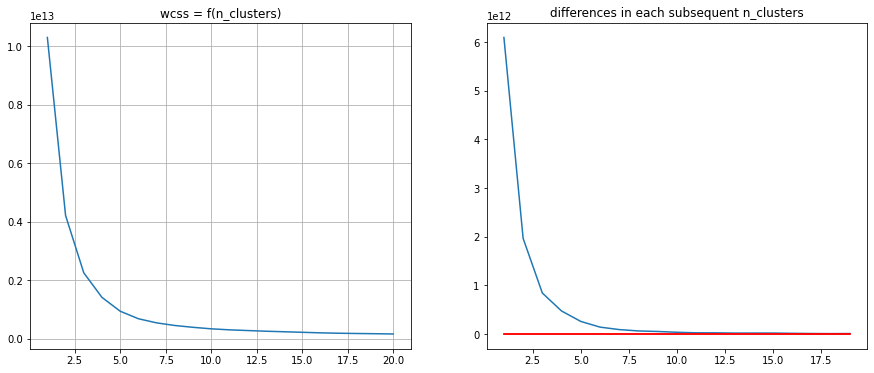

In [4]:
elbow_method.plot(500)